In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os.path as op
from csv import writer
import math
import cmath
import pickle

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model,Sequential,load_model
from keras.layers import Input, Embedding
from keras.layers import Dense, Bidirectional
from keras.layers.recurrent import LSTM
import keras.metrics as metrics
import itertools
from tensorflow.python.keras.utils.data_utils import Sequence
from decimal import Decimal
from keras.layers import Conv1D,MaxPooling1D,Flatten,Dense

In [3]:
A1=np.empty((0,5),dtype='float32')
U1=np.empty((0,7),dtype='float32')
node=['150','149','147','144','142','140','136','61']
mon=['Apr','Mar','Aug','Jun','Jul','Sep','May','Oct']
for j in node:
  for i in mon:
    inp= pd.read_csv('../../../data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[1,2,3,15,16])
    out= pd.read_csv('../../../data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[5,6,7,8,17,18,19])
    
    inp=np.array(inp,dtype='float32')
    out=np.array(out,dtype='float32')
    
    A1=np.append(A1, inp, axis=0)
    U1=np.append(U1, out, axis=0)

print(A1)
print(U1)

[[1.50000e+02 1.90401e+05 7.25000e+02 2.75500e+01 8.03900e+01]
 [1.50000e+02 1.90401e+05 8.25000e+02 2.75600e+01 8.03300e+01]
 [1.50000e+02 1.90401e+05 9.25000e+02 2.75800e+01 8.02400e+01]
 ...
 [6.10000e+01 1.91020e+05 1.94532e+05 2.93700e+01 7.52100e+01]
 [6.10000e+01 1.91020e+05 1.94632e+05 2.93500e+01 7.52700e+01]
 [6.10000e+01 1.91020e+05 1.94732e+05 2.93400e+01 7.53000e+01]]
[[ 28.     3.   -52.   ...  16.97  19.63  20.06]
 [ 28.    15.   -53.   ...  16.63  19.57  23.06]
 [ 31.    16.   -55.   ...  17.24  19.98  20.24]
 ...
 [ 76.    12.   -76.   ...   3.47   3.95   4.35]
 [ 75.    13.   -76.   ...   3.88   4.33   4.42]
 [ 76.    12.   -75.   ...   3.46   4.07   4.28]]


In [4]:
from sklearn.decomposition import SparsePCA
import warnings
scaler_obj1=SparsePCA()
scaler_obj2=SparsePCA()
X1=scaler_obj1.fit_transform(A1)
Y1=scaler_obj2.fit_transform(U1)

warnings.filterwarnings(action='ignore', category=UserWarning)


X1=X1[:,np.newaxis,:]
Y1=Y1[:,np.newaxis,:]

In [5]:
from keras import backend as K
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [6]:
model = Sequential()
model.add(keras.Input(shape=(1,5)))
model.add(tf.keras.layers.GRU(14,activation="tanh",use_bias=True,kernel_initializer="glorot_uniform",bias_initializer="zeros", 
                                kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                                bias_regularizer=keras.regularizers.l2(1e-4),
                                activity_regularizer=keras.regularizers.l2(1e-5)))
model.add(keras.layers.Dropout(.1))
model.add(Dense(7))
model.add(keras.layers.BatchNormalization(axis=-1,momentum=0.99,epsilon=0.001,center=True,scale=True,
                                beta_initializer="zeros",gamma_initializer="ones",
                                moving_mean_initializer="zeros",moving_variance_initializer="ones",trainable=True))
model.add(keras.layers.ReLU())
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),loss='mse',metrics=['accuracy','mse','mae',rmse])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 14)                882       
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense (Dense)               (None, 7)                 105       
                                                                 
 batch_normalization (BatchN  (None, 7)                28        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 7)                 0         
                                                                 
Total params: 1,015
Trainable params: 1,001
Non-trainable params: 14
_____________________________________________________

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

history2 = model.fit(x_train,y_train,batch_size=256,epochs=50, validation_split=0.1)

Epoch 1/50
4563/4563 [==============================] - 86s 18ms/step - loss: 2251108864.0000 - accuracy: 0.1482 - mse: 2251204352.0000 - mae: 95.7489 - rmse: 195.1403 - val_loss: 30172.4727 - val_accuracy: 0.1869 - val_mse: 30172.5137 - val_mae: 72.1877 - val_rmse: 136.1254
Epoch 2/50
4563/4563 [==============================] - 144s 32ms/step - loss: 2251113728.0000 - accuracy: 0.1534 - mse: 2251208960.0000 - mae: 95.7374 - rmse: 195.1376 - val_loss: 30172.3496 - val_accuracy: 0.1861 - val_mse: 30172.3906 - val_mae: 72.1798 - val_rmse: 136.1245- accuracy: 0.1530 - mse: 53109080.0000 - mae: 77 - ETA: 1:04 - loss: 52482488.0000 - accuracy: 0.1530  - ETA: 40s - loss: 2979594752.0000 - accuracy: 0.1531 - mse: 2979594752.0000 - mae: 9 - ETA: 37s - loss: 2919680256.0000 - accuracy: 0.1532 - m - ETA: 19s - loss: 2565431040.0000 - accuracy: 0.1532 - mse: 2565431040.0 - ETA: - ETA: 7s - loss: 2378394368.0000 - accuracy: 0.1533 - mse: 2378394368.0000 - mae: 96.9594 - rmse:  - ETA: 7s - loss: 2

4563/4563 [==============================] - 85s 19ms/step - loss: 2251095296.0000 - accuracy: 0.2465 - mse: 2251190784.0000 - mae: 95.6579 - rmse: 195.1229 - val_loss: 30169.5938 - val_accuracy: 0.3059 - val_mse: 30169.6348 - val_mae: 72.1075 - val_rmse: 136.1058
Epoch 27/50
4563/4563 [==============================] - 84s 18ms/step - loss: 2251120640.0000 - accuracy: 0.2514 - mse: 2251215872.0000 - mae: 95.6571 - rmse: 195.1219 - val_loss: 30169.2383 - val_accuracy: 0.3148 - val_mse: 30169.2793 - val_mae: 72.1057 - val_rmse: 136.1033
Epoch 28/50
4563/4563 [==============================] - 84s 18ms/step - loss: 2251122432.0000 - accuracy: 0.2537 - mse: 2251217920.0000 - mae: 95.6564 - rmse: 195.1218 - val_loss: 30169.5117 - val_accuracy: 0.3148 - val_mse: 30169.5527 - val_mae: 72.1068 - val_rmse: 136.1047
Epoch 29/50
4563/4563 [==============================] - 84s 19ms/step - loss: 2251116544.0000 - accuracy: 0.2557 - mse: 2251212032.0000 - mae: 95.6553 - rmse: 195.1206 - val_loss: 

4563/4563 [==============================] - 85s 19ms/step - loss: 2251111936.0000 - accuracy: 0.2556 - mse: 2251207424.0000 - mae: 95.6442 - rmse: 195.1145 - val_loss: 30168.6152 - val_accuracy: 0.3356 - val_mse: 30168.6543 - val_mae: 72.0956 - val_rmse: 136.0973
Epoch 48/50
4563/4563 [==============================] - 85s 19ms/step - loss: 2251118592.0000 - accuracy: 0.2511 - mse: 2251213824.0000 - mae: 95.6445 - rmse: 195.1160 - val_loss: 30168.5781 - val_accuracy: 0.3357 - val_mse: 30168.6172 - val_mae: 72.0952 - val_rmse: 136.0969 78.5567  - ETA: 36s - loss: 43 - ETA: 31s - loss: 93930064.0000 - accuracy: 0.2511 - mse: 93930064.0000 - ma
Epoch 49/50
4563/4563 [==============================] - 85s 19ms/step - loss: 2251093760.0000 - accuracy: 0.2483 - mse: 2251189248.0000 - mae: 95.6445 - rmse: 195.1167 - val_loss: 30168.5508 - val_accuracy: 0.3357 - val_mse: 30168.5898 - val_mae: 72.0947 - val_rmse: 136.0966 2332490752. - ETA: 1s - loss: 2269224192.0000 - acc
Epoch 50/50
4563/456

In [8]:
model.evaluate(x_test,y_test)

13518/13518 [==============================] - 158s 12ms/step - loss: 1403851.0000 - accuracy: 0.3398 - mse: 1403864.5000 - mae: 73.4765 - rmse: 139.6054


[1403851.0,
 0.3397790491580963,
 1403864.5,
 73.47650909423828,
 139.6053924560547]

In [9]:
model.evaluate(x_train,y_train)

40554/40554 [==============================] - 468s 12ms/step - loss: 2025999232.0000 - accuracy: 0.3399 - mse: 2026011776.0000 - mae: 93.2645 - rmse: 189.1921s - loss: 2025999232.0000 - accuracy: 0.3399 - mse: 2026011776.0000 - mae: 93.2645 - rmse: 189.19


[2025999232.0,
 0.33990588784217834,
 2026011776.0,
 93.26451110839844,
 189.19207763671875]

In [10]:
df1=pd.DataFrame(history2.history['loss'],columns=["Loss"])
df1=df1.join(pd.DataFrame(history2.history["val_loss"],columns=["Val Loss"]))
df1=df1.join(pd.DataFrame(history2.history["accuracy"],columns=['Accuracy']))
df1=df1.join(pd.DataFrame(history2.history["val_accuracy"],columns=['Val Accuracy']))
df1=df1.join(pd.DataFrame(history2.history["mse"],columns=['MSE']))
df1=df1.join(pd.DataFrame(history2.history["val_mse"],columns=['Val MSE']))
df1=df1.join(pd.DataFrame(history2.history["mae"],columns=['MAE']))
df1=df1.join(pd.DataFrame(history2.history["val_mae"],columns=['Val MAE']))
df1=df1.join(pd.DataFrame(history2.history["rmse"],columns=['RMSE']))
df1=df1.join(pd.DataFrame(history2.history["val_mse"],columns=['Val RMSE']))
df1

,Loss,Val Loss,Accuracy,Val Accuracy,MSE,Val MSE,MAE,Val MAE,RMSE,Val RMSE
0,2.251109e+09,30172.472656,0.148205,0.186930,2.251204e+09,30172.513672,95.748856,72.187698,195.140305,30172.513672
1,2.251114e+09,30172.349609,0.153387,0.186059,2.251209e+09,30172.390625,95.737396,72.179794,195.137558,30172.390625
2,2.251108e+09,30172.214844,0.154239,0.187159,2.251203e+09,30172.257812,95.729149,72.172310,195.136948,30172.257812
3,2.251119e+09,30172.005859,0.156532,0.187982,2.251215e+09,30172.046875,95.720940,72.165260,195.136154,30172.046875
4,2.251111e+09,30171.794922,0.157951,0.188340,2.251207e+09,30171.835938,95.712990,72.159424,195.133865,30171.835938
5,2.251103e+09,30171.757812,0.157701,0.188085,2.251198e+09,30171.798828,95.706993,72.154663,195.132965,30171.798828
6,2.251108e+09,30171.615234,0.156568,0.187779,2.251203e+09,30171.654297,95.700851,72.150291,195.131699,30171.654297
7,2.251100e+09,30171.322266,0.155022,0.187678,2.251195e+09,30171.361328,95.696037,72.145363,195.131363,30171.361328
8,2.251108e+09,30170.976562,0.219851,0.251387,2.251204e+09,30171.015625,95.688553,72.134140,195.131516,30171.015625
9,2.251111e+09,30171.191406,0.232986,0.253294,2.251206e+09,30171.230469,95.683891,72.133339,195.130386,30171.230469


In [11]:
df1.to_excel("GRU_tanh_mse.xlsx")

In [12]:
model_json = model.to_json()
with open("gru_tanh_mse.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("gru_tanh_mse.h5")
print("Saved model to disk")

Saved model to disk


In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

from keras.models import model_from_json
json_file = open('gru_tanh_mse.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("gru_tanh_mse.h5")
print("Loaded model from disk")
loaded_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),loss='mse',metrics=['accuracy','mse','mae',rmse])
print(loaded_model.evaluate(x_train, y_train, verbose=0))

Loaded model from disk
[2025999232.0, 0.33990588784217834, 2026011776.0, 93.26451110839844, 189.19207763671875]


In [14]:
print(loaded_model.evaluate(x_test,y_test))

13518/13518 [==============================] - 158s 12ms/step - loss: 1403851.0000 - accuracy: 0.3398 - mse: 1403864.5000 - mae: 73.4765 - rmse: 139.6054s - loss: 1409669.2500 - accuracy: 0.3398 - mse: 1409669.2500 - mae: 
[1403851.0, 0.3397790491580963, 1403864.5, 73.47650909423828, 139.6053924560547]


In [15]:
print(loaded_model.evaluate(x_train,y_train))

40554/40554 [==============================] - 471s 12ms/step - loss: 2025999232.0000 - accuracy: 0.3399 - mse: 2026011776.0000 - mae: 93.2645 - rmse: 189.1921
[2025999232.0, 0.33990588784217834, 2026011776.0, 93.26451110839844, 189.19207763671875]


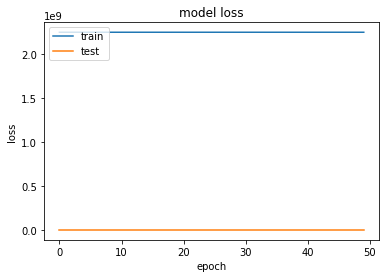

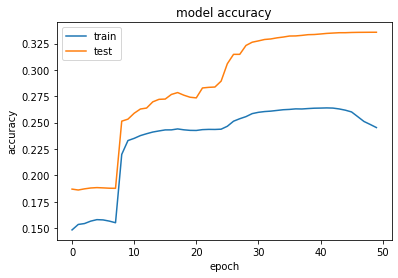

In [16]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

y_test_pred=model.predict(x_test)
y_test_pred

array([[0.        , 0.19841433, 0.08133161, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.19841433, 0.08133161, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.19841433, 0.08133161, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.03905594, 0.        , 0.18342948, ..., 0.10529424, 0.        ,
        0.        ],
       [0.        , 0.19841433, 0.08133161, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.19841433, 0.08133161, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [18]:
y_test

array([[[-5.4707150e+01,  3.0351229e+01,  2.6544733e+02, ...,
         -3.1806244e+01, -5.8596706e-01, -3.9942199e-01]],

       [[-4.0422195e+01, -3.2006611e+01,  3.9725319e+01, ...,
         -1.6595110e+01, -4.2555341e-01,  4.5112044e-01]],

       [[-5.2611900e+01,  6.3103738e+00, -5.3949774e+02, ...,
          2.1971800e+01,  4.6926007e+00,  9.8132938e-01]],

       ...,

       [[-8.7108231e+01, -3.0540722e+01, -4.3651901e+02, ...,
          6.8366714e+01,  3.2034805e-01,  1.0517381e+00]],

       [[-5.0692768e+01,  1.9452883e+01,  1.6842407e+02, ...,
         -2.2491724e+01, -1.5624888e+00,  2.1897414e-01]],

       [[-9.4654129e+01, -6.0080070e+01,  1.5260393e+02, ...,
         -2.9023485e+01, -8.3189094e-01, -4.2029378e-01]]], dtype=float32)

In [19]:
y_test=y_test[:,0]

In [20]:
from numpy import savetxt
savetxt('gru_tanh_mse_y_test_pred.csv', y_test_pred[:1001], delimiter=',')

In [21]:
from numpy import savetxt
savetxt('gru_tanh_mse_y_test.csv', y_test[:1001], delimiter=',')

In [ ]:
#completed